# Exploratory Data Analysis + Handling Missing Data

`TODO`

- Group events per RunID and date
- Examine "impossible" values
- Implement Haversine formula to fill in `speed` = NaN with `Latitude` and `Longitude`
- Tidy script 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# load full data
data = pd.read_csv('processed_data/first_pass.csv')
data

,RunID,Time,Latitude,Longitude,Elevation,Distance,HeartRate,Cadence,Speed
0,10018226548,2023-06-26T18:22:43.350000,52.225510,4.504773,-1.981,283.399994,73,86.0,NaN
1,10018226548,2023-06-26T18:22:44.350000,52.225522,4.504797,-1.829,286.200012,73,87.0,NaN
2,10018226548,2023-06-26T18:22:45.350000,52.225538,4.504827,-1.676,288.500000,73,87.0,NaN
3,10018226548,2023-06-26T18:22:46.350000,52.225558,4.504863,-1.524,290.799988,74,86.0,NaN
4,10018226548,2023-06-26T18:22:47.350000,52.225573,4.504897,-1.372,293.100006,75,86.0,NaN
...,...,...,...,...,...,...,...,...,...
1678681,9893577317,2023-06-07T18:42:49.693000,52.224350,4.501980,1.067,6122.700195,144,86.0,NaN
1678682,9893577317,2023-06-07T18:42:50.693000,52.224357,4.501937,1.067,6125.799805,144,86.0,NaN
1678683,9893577317,2023-06-07T18:42:51.693000,52.224362,4.501897,0.914,6128.700195,143,85.0,NaN
1678684,9893577317,2023-06-07T18:42:52.693000,52.224365,4.501860,0.914,6131.600098,143,83.0,NaN


In [3]:
# convert to datetime
data['Time'] = pd.to_datetime(data['Time'], errors = 'coerce', utc=True)

# extract the date in YYYY-MM-DD
data['Date'] = data['Time'].dt.date

In [4]:
# aggregate functions
agg_funcs = {
    'Elevation': 'mean',
    'Distance': 'max',
    'HeartRate': 'mean',
    'Cadence': 'mean',
    'Speed': 'mean'}

# aggregate data per run
data_per_run = data[['RunID', 
                     'Date', 
                     'Elevation', 
                     'Distance', 
                     'HeartRate', 
                     'Cadence', 
                     'Speed']].groupby(['RunID', 'Date']).agg(agg_funcs).reset_index()

In [5]:
data_per_run

,RunID,Date,Elevation,Distance,HeartRate,Cadence,Speed
0,741590575,2016-08-10,-0.559788,NaN,155.927865,78.644124,3.062487
1,744634852,2016-08-14,6.235153,NaN,149.532697,84.595130,2.783646
2,749703915,2016-08-17,8.753312,NaN,136.597015,71.163445,2.484476
3,749703916,2016-08-17,-0.974376,NaN,152.375986,75.558772,3.034197
4,753631318,2016-08-21,1.483430,NaN,153.641073,84.351686,3.038020
...,...,...,...,...,...,...,...
501,12249284502,2024-05-22,-2.910637,4483.799805,134.003289,75.805921,NaN
502,12278091080,2024-05-26,0.121194,11042.299805,140.533900,79.648360,NaN
503,12305381020,2024-05-29,2.958158,6090.899902,136.324275,82.432367,NaN
504,12344844634,2024-06-03,-3.972775,364.899994,132.697436,65.215385,NaN


## Descriptive Analysis: Per run

In [8]:
descriptive_stats = data_per_run.describe()
pd.set_option('display.float_format', '{:.2f}'.format)
descriptive_stats[['Elevation', 'Distance', 'HeartRate', 'Cadence', 'Speed']]

,Elevation,Distance,HeartRate,Cadence,Speed
count,504.00,499.00,506.00,496.00,23.00
mean,5.86,9023.78,140.03,78.81,2.60
std,71.48,4725.29,19.17,10.82,0.43
min,-157.46,0.00,0.00,10.56,1.57
25%,-2.56,6058.15,133.81,74.88,2.39
50%,0.74,9272.00,141.15,81.84,2.68
75%,3.75,11739.25,148.51,85.70,2.82
max,1214.28,43286.20,198.74,94.05,3.42


In [9]:
data_per_run.isna().sum()

RunID          0
Date           0
Elevation      2
Distance       7
HeartRate      0
Cadence       10
Speed        483
dtype: int64

In [10]:
data[data["Distance"] == 0]

,RunID,Time,Latitude,Longitude,Elevation,Distance,HeartRate,Cadence,Speed,Date
7786,1010000744,2017-03-22 18:15:12+00:00,52.26,4.54,0.91,0.00,78,NaN,NaN,2017-03-22
7787,1010000744,2017-03-22 18:15:13+00:00,52.26,4.54,0.91,0.00,77,0.00,NaN,2017-03-22
23108,1021048125,2017-03-29 17:16:39+00:00,52.26,4.54,-2.29,0.00,90,0.00,NaN,2017-03-29
23109,1021048125,2017-03-29 17:16:40+00:00,52.26,4.54,-2.29,0.00,91,0.00,NaN,2017-03-29
45062,1032868566,2017-04-05 17:20:36+00:00,52.26,4.54,-1.07,0.00,95,0.00,NaN,2017-04-05
...,...,...,...,...,...,...,...,...,...,...
1331476,7350557883,2022-03-30 17:15:39.357000+00:00,52.26,4.54,-15.54,0.00,72,0.00,NaN,2022-03-30
1331477,7350557883,2022-03-30 17:15:40.357000+00:00,52.26,4.54,-15.54,0.00,72,0.00,NaN,2022-03-30
1331478,7350557883,2022-03-30 17:15:41.357000+00:00,52.26,4.54,-15.54,0.00,72,0.00,NaN,2022-03-30
1331479,7350557883,2022-03-30 17:15:42.357000+00:00,52.26,4.54,-15.54,0.00,72,0.00,NaN,2022-03-30


In [11]:
# two runs with no distance covered whatsoever
# 1983036631: NaN distances, but coordinates present
# 2617828766: Distances of 0 at all times and four minute session, but coordinates present
data_per_run[data_per_run["Distance"] == 0]

,RunID,Date,Elevation,Distance,HeartRate,Cadence,Speed
113,1983036631,2018-09-18,-2.45,0.00,165.33,91.50,NaN
156,2617828766,2019-06-19,-1.86,0.00,133.87,84.55,NaN


In [12]:
data[data["RunID"] == 2617828766]

,RunID,Time,Latitude,Longitude,Elevation,Distance,HeartRate,Cadence,Speed,Date
662694,2617828766,2019-06-19 17:20:05+00:00,52.26,4.54,-0.76,0.00,122,0.00,NaN,2019-06-19
662695,2617828766,2019-06-19 17:20:06+00:00,52.26,4.54,-0.76,0.00,122,0.00,NaN,2019-06-19
662696,2617828766,2019-06-19 17:20:10+00:00,52.26,4.54,-0.76,0.00,126,84.00,NaN,2019-06-19
662697,2617828766,2019-06-19 17:20:11+00:00,52.26,4.54,-0.76,0.00,127,88.00,NaN,2019-06-19
662698,2617828766,2019-06-19 17:20:12+00:00,52.26,4.54,-0.76,0.00,128,88.00,NaN,2019-06-19
...,...,...,...,...,...,...,...,...,...,...
662966,2617828766,2019-06-19 17:24:40+00:00,52.26,4.54,-2.74,0.00,116,0.00,NaN,2019-06-19
662967,2617828766,2019-06-19 17:24:41+00:00,52.26,4.54,-2.74,0.00,113,0.00,NaN,2019-06-19
662968,2617828766,2019-06-19 17:24:42+00:00,52.26,4.54,-2.74,0.00,112,0.00,NaN,2019-06-19
662969,2617828766,2019-06-19 17:24:43+00:00,52.26,4.54,-2.74,0.00,110,0.00,NaN,2019-06-19


## Descriptive Analysis: Full

In [13]:
descriptive_stats = data.describe()
pd.set_option('display.float_format', '{:.2f}'.format)
descriptive_stats[['Elevation', 'Distance', 'HeartRate', 'Cadence', 'Speed']]

,Elevation,Distance,HeartRate,Cadence,Speed
count,1635325.00,1627379.00,1678686.00,1640012.00,73353.00
mean,5.79,5680.97,141.32,78.48,2.57
std,72.00,4327.72,24.00,23.62,0.87
min,-169.62,0.00,0.00,0.00,0.00
25%,-3.50,2516.30,133.00,85.00,2.50
50%,0.15,4865.30,145.00,87.00,2.80
75%,5.18,8101.90,155.00,89.00,3.00
max,1310.20,43286.20,235.00,124.00,9.50


In [14]:
# Missing values
data.isna().sum()

RunID              0
Time               0
Latitude        9169
Longitude       9169
Elevation      43361
Distance       51307
HeartRate          0
Cadence        38674
Speed        1605333
Date               0
dtype: int64

In [15]:
print("Distance = 0:", len(data[data['Distance'] == 0]))
print("HeartRate = 0:", len(data[data['HeartRate'] == 0]))

# makes sense when runner takes a break
print("Cadence = 0:", len(data[data['HeartRate'] == 0]))

Distance = 0: 708
HeartRate = 0: 1375
Cadence = 0: 1375


In [16]:
# Only one run which recorded heartRate = 0
data[data['HeartRate'] == 0]["RunID"].unique()

array([787870341], dtype=int64)

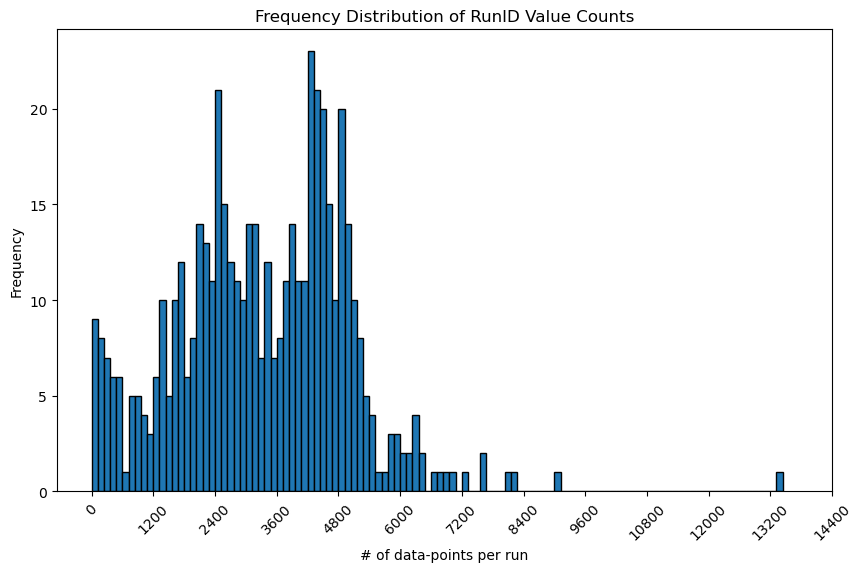

In [31]:
# calculate the value counts for 'RunID'
value_counts = data['RunID'].value_counts()

# define the bins for the range of value counts
bin_width = 120
max_value = value_counts.max()
bins = range(0, max_value + bin_width, bin_width)

# create a histogram of the value counts
plt.figure(figsize=(10, 6))
plt.hist(value_counts, bins=bins, edgecolor='black')
plt.xlabel('# of data-points per run')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of RunID Value Counts')

# set x-axis ticks to appear at a larger interval to reduce clutter
tick_interval = bin_width * 10  # Adjust this interval as needed
plt.xticks(range(0, max_value + tick_interval, tick_interval), rotation=45)

# show the plot
plt.show()

## Time-series Analysis: Full

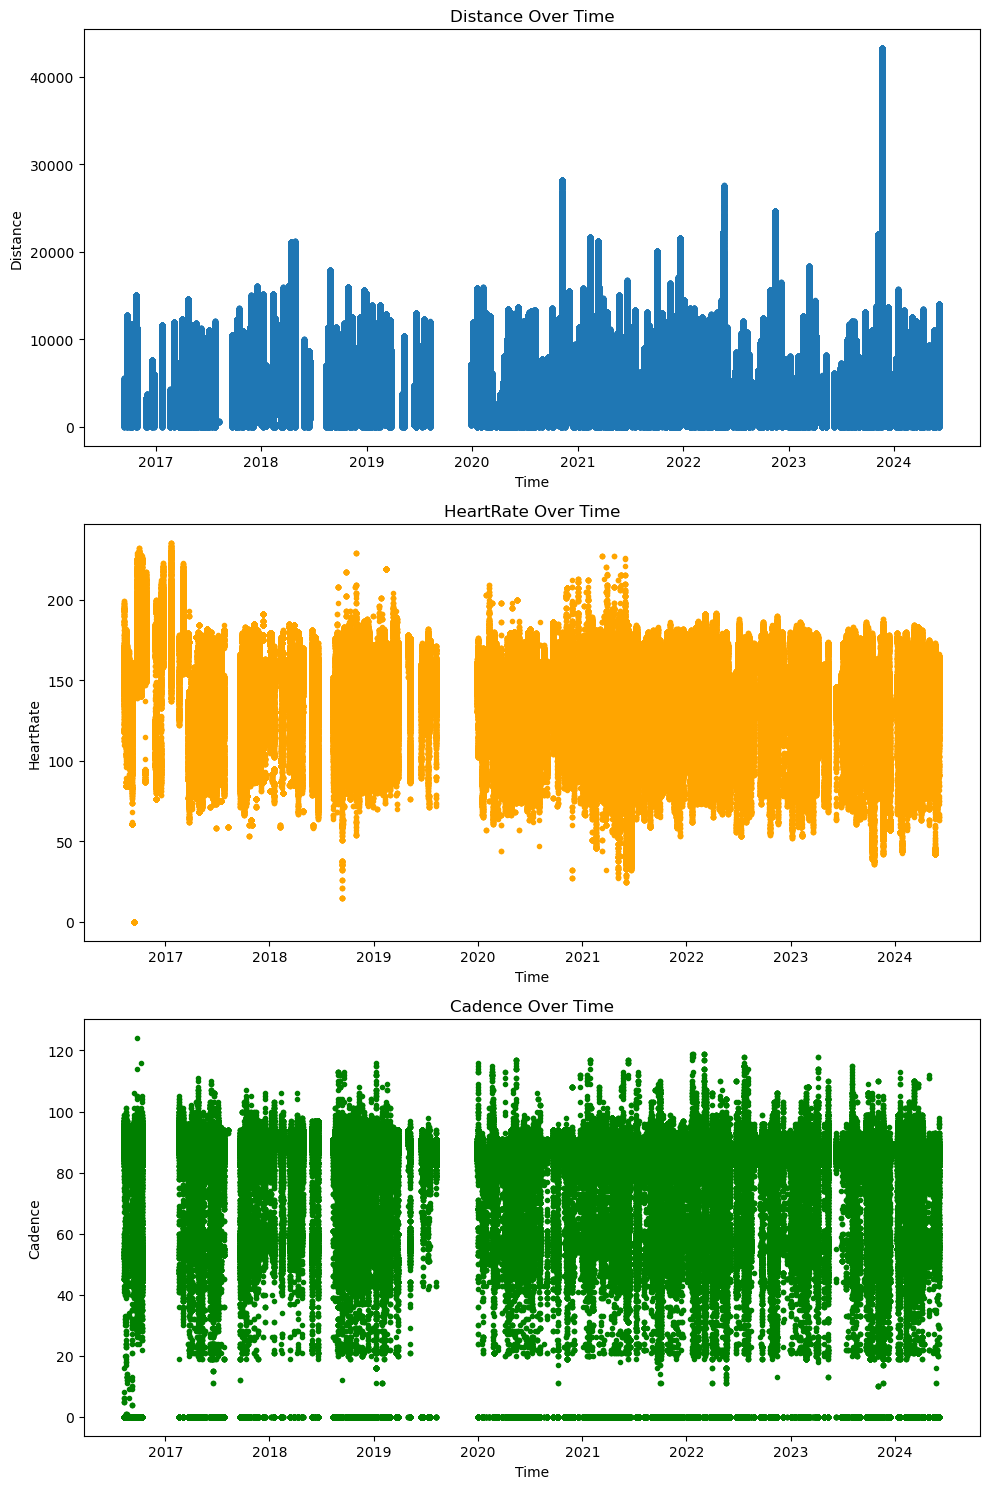

In [71]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# distance over time
ax[0].plot(data['Time'], data['Distance'], '.', label = 'Distance')
ax[0].set_title('Distance Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Distance')

# heartRate over time
ax[1].plot(data['Time'], data['HeartRate'], '.', label = 'HeartRate', color = 'orange')
ax[1].set_title('HeartRate Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('HeartRate')

# cadence over time
ax[2].plot(data['Time'], data['Cadence'], '.', label = 'Cadence', color = 'green')
ax[2].set_title('Cadence Over Time')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Cadence')

plt.tight_layout()
plt.show()

## Time-series Analysis: Per run

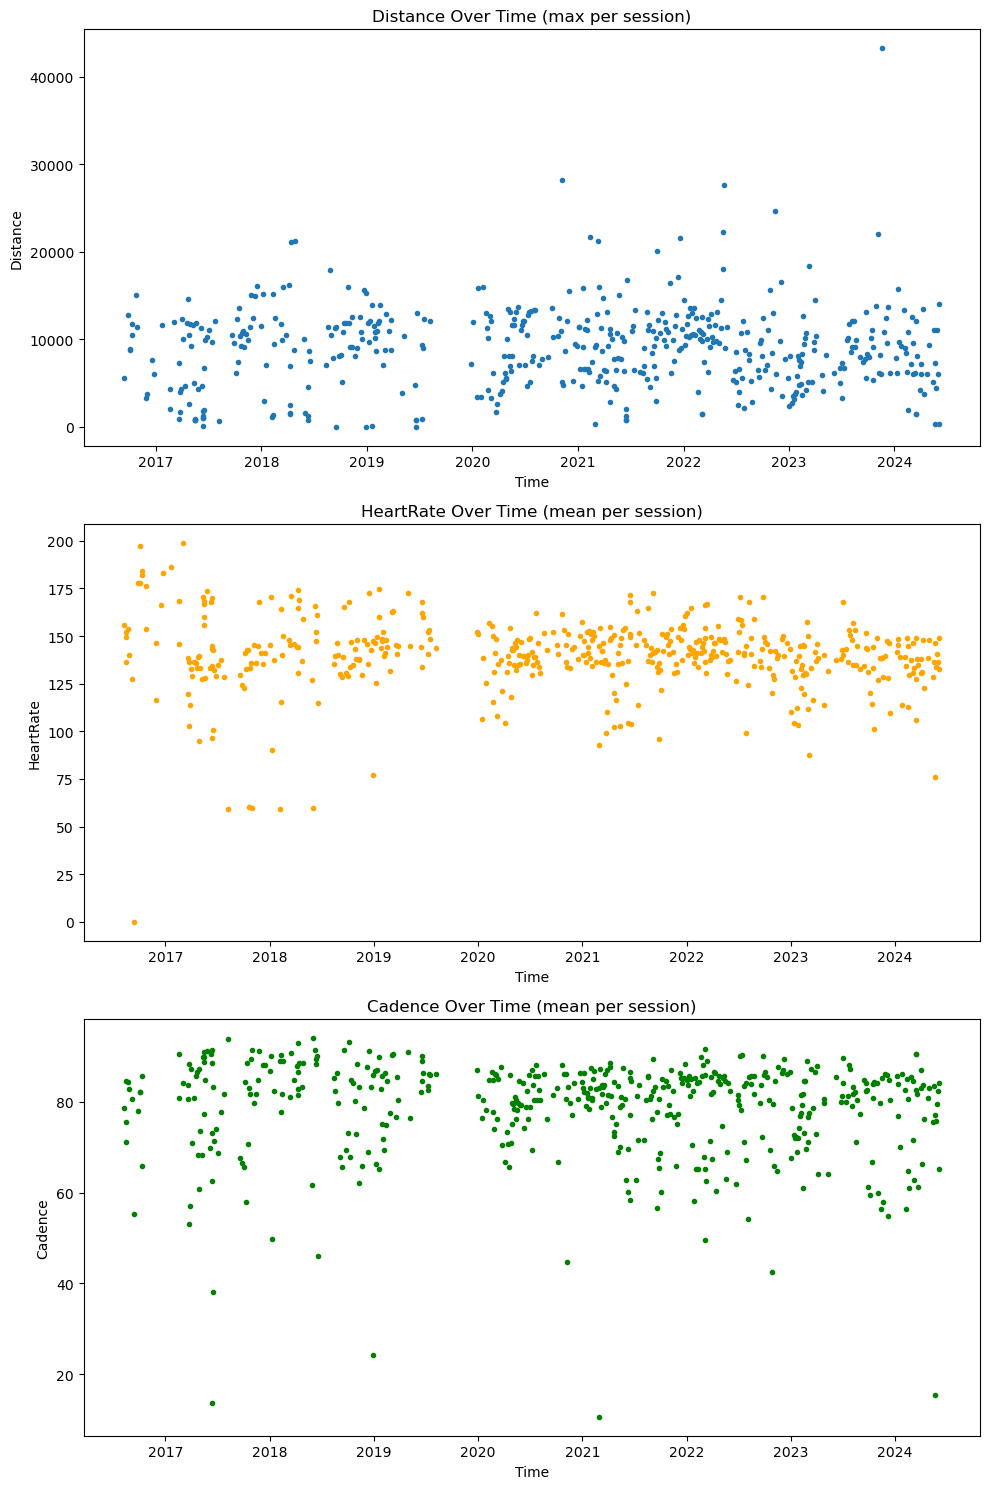

In [142]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# distance over time
ax[0].plot(data_per_run['Date'], data_per_run['Distance'], '.', label = 'Distance')
ax[0].set_title('Distance Over Time (max per session)')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Distance')

# heartRate over time
ax[1].plot(data_per_run['Date'], data_per_run['HeartRate'], '.', label = 'HeartRate', color = 'orange')
ax[1].set_title('HeartRate Over Time (mean per session)')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('HeartRate')

# cadence over time
ax[2].plot(data_per_run['Date'], data_per_run['Cadence'], '.', label = 'Cadence', color = 'green')
ax[2].set_title('Cadence Over Time (mean per session)')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Cadence')

plt.tight_layout()
plt.show()

In [74]:
# examine average heartrate below 75
data_per_run[data_per_run['HeartRate'] < 75]

,RunID,Date,Elevation,Distance,HeartRate,Cadence,Speed
7,787870341,2016-09-14,-1.844364,5575.000000,0.000000,55.288727,2.333236
59,1241530709,2017-08-09,1.463000,623.400024,59.000000,93.866667,NaN
67,1347907211,2017-10-22,-1.338714,9285.900391,60.285714,83.071429,NaN
70,1363595103,2017-11-01,5.943467,9156.000000,60.000000,91.400000,NaN
82,1508216362,2018-02-07,-4.470667,1107.099976,59.333333,89.066667,NaN
100,1730901813,2018-06-01,1.579947,1546.199951,59.578947,94.052632,NaN


In [155]:
data[data['RunID'] == 787870341]

,RunID,Time,Latitude,Longitude,Elevation,Distance,HeartRate,Cadence,Speed,Date
1429591,787870341,2016-09-14 17:47:10+00:00,NaN,NaN,1.00,NaN,0,45.00,1.20,2016-09-14
1429592,787870341,2016-09-14 17:47:11+00:00,NaN,NaN,1.00,5.00,0,48.00,1.10,2016-09-14
1429593,787870341,2016-09-14 17:47:12+00:00,NaN,NaN,1.00,NaN,0,53.00,1.20,2016-09-14
1429594,787870341,2016-09-14 17:47:14+00:00,NaN,NaN,1.00,11.00,0,60.00,1.70,2016-09-14
1429595,787870341,2016-09-14 17:47:17+00:00,NaN,NaN,0.00,16.00,0,74.00,1.80,2016-09-14
...,...,...,...,...,...,...,...,...,...,...
1430961,787870341,2016-09-14 18:23:16+00:00,NaN,NaN,-2.00,NaN,0,0.00,0.00,2016-09-14
1430962,787870341,2016-09-14 18:23:17+00:00,NaN,NaN,-2.00,NaN,0,0.00,0.00,2016-09-14
1430963,787870341,2016-09-14 18:23:18+00:00,NaN,NaN,-2.00,NaN,0,0.00,0.00,2016-09-14
1430964,787870341,2016-09-14 18:23:19+00:00,NaN,NaN,-2.00,NaN,0,0.00,0.00,2016-09-14


## Frequency Analysis: Full

C:\Users\Jason\AppData\Local\Temp\ipykernel_4932\3613998802.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['YearMonth'] = data['Time'].dt.to_period('M')


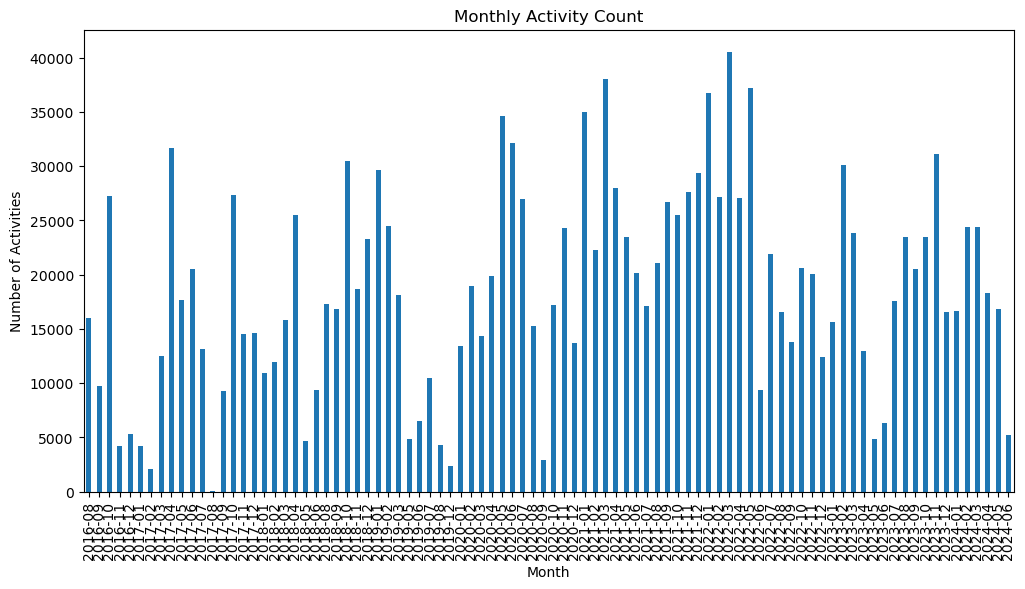

In [25]:
# extract the date part for categorical analysis
data['Date'] = data['Time'].dt.date

# extract year and month for grouping
data['YearMonth'] = data['Time'].dt.to_period('M')

# extract the day of the week for grouping
data['Weekday'] = data['Time'].dt.day_name()

# group by year and month and count activities
monthly_activity_count = data.groupby('YearMonth').size()

# group by weekday and count activities
weekday_activity_count = data.groupby('Weekday').size()

# plot monthly activity count
plt.figure(figsize=(12, 6))
monthly_activity_count.plot(kind='bar')
plt.title('Monthly Activity Count')
plt.xlabel('Month')
plt.ylabel('Number of Activities')
plt.show()

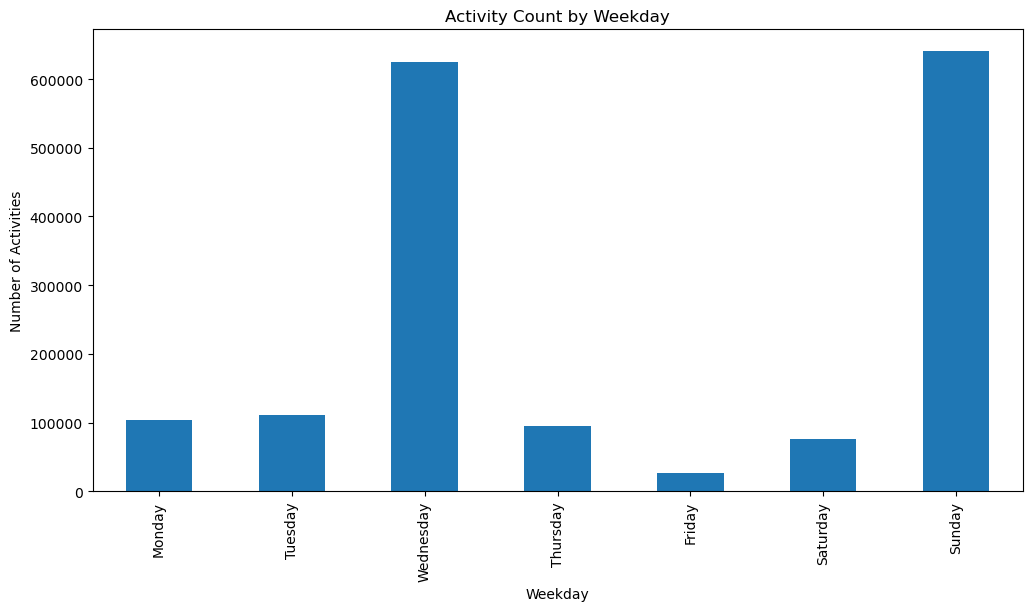

In [26]:
# to ensure the order is Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_activity_count = weekday_activity_count.reindex(weekday_order)

# plot weekday activity count
plt.figure(figsize=(12, 6))
weekday_activity_count.plot(kind='bar')
plt.title('Activity Count by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Activities')
plt.show()

## Correlation Heatmap

TODO: Perform Haversine formula on NaN values in column `speed` to limit dropped rows.

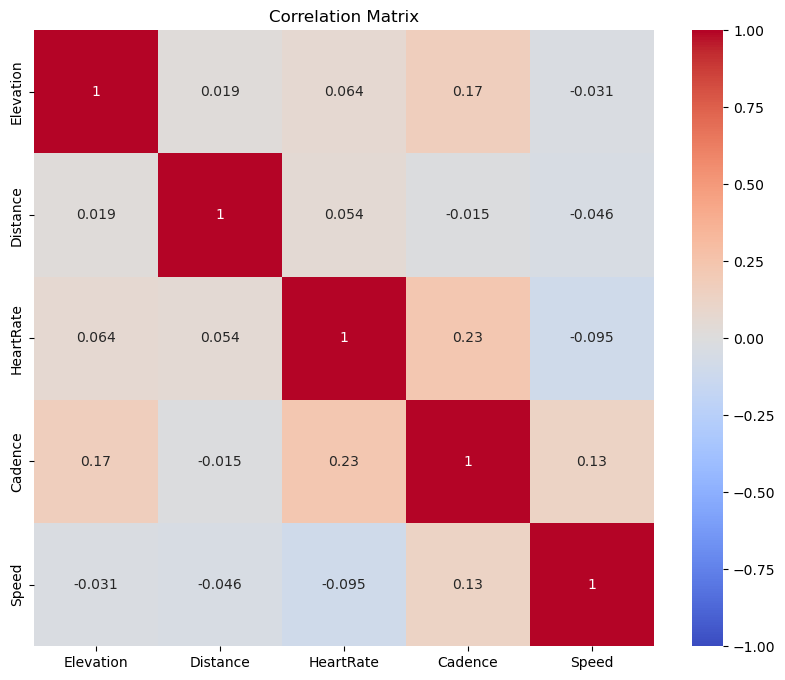

In [16]:
# drop rows with NaN values for correlation analysis
corr_data = data[['Elevation', 'Distance', 'HeartRate', 'Cadence', 'Speed']].dropna()
correlation_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Checking outliers

Outliers defined by Z-score > 3

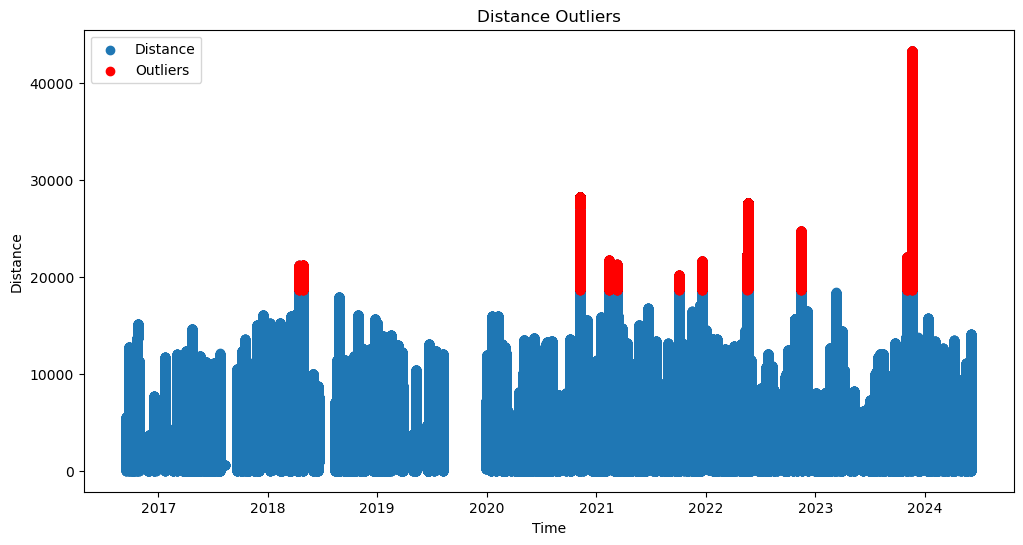

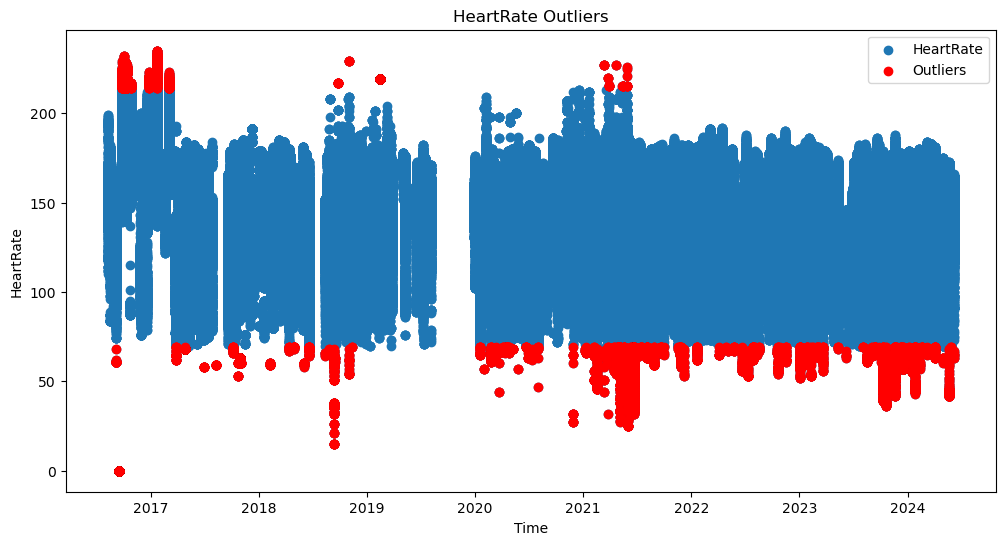

In [17]:
import numpy as np

# identify outliers in 'Distance'
distance_outliers = data[np.abs(data['Distance'] - data['Distance'].mean()) > (3 * data['Distance'].std())]

# identify outliers in 'HeartRate'
heartrate_outliers = data[np.abs(data['HeartRate'] - data['HeartRate'].mean()) > (3 * data['HeartRate'].std())]

# plot distance outliers
plt.figure(figsize=(12, 6))
plt.scatter(data['Time'], data['Distance'], label='Distance')
plt.scatter(distance_outliers['Time'], distance_outliers['Distance'], color='red', label='Outliers')
plt.title('Distance Outliers')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()

# plot HeartRate outliers
plt.figure(figsize=(12, 6))
plt.scatter(data['Time'], data['HeartRate'], label='HeartRate')
plt.scatter(heartrate_outliers['Time'], heartrate_outliers['HeartRate'], color='red', label='Outliers')
plt.title('HeartRate Outliers')
plt.xlabel('Time')
plt.ylabel('HeartRate')
plt.legend()
plt.show()

In [ ]:
distance_outliers['Distance'].unique()

In [ ]:
heartrate_outliers['HeartRate'].unique()

## K-means Clustering

C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Jason\a

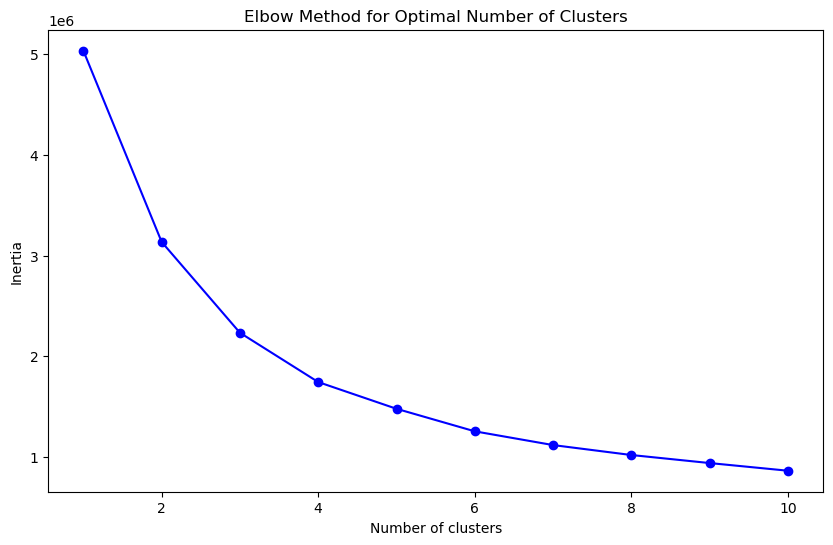

C:\Users\Jason\anaconda3\envs\py39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


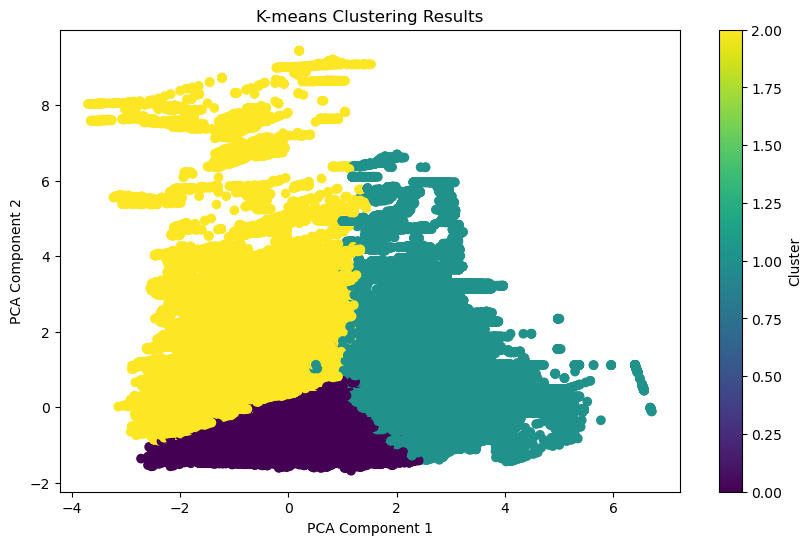

In [34]:
# select features for clustering
features = data[['Distance', 'HeartRate', 'Cadence']]

# filling missing values with the mean of the column
features = features.fillna(features.mean())

# standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# determine the optimal number of clusters (elbow method)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# choose the optimal clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_features)

# visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=data['Cluster'], cmap='viridis', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering')
plt.colorbar(label='Cluster')
plt.show()